# Dataset exploration

Before starting, please:
1. make sure to install all the lilbraries using environment.yml
2. download data from [link here]
3. place data in your favorite folder
4. change config.json accordingly

In [1]:
import sys
sys.path.append('..')

import src.config as config
dataset_path = config.get_attribute('dataset_path', prefix='../')

import os
import mne
import json
import numpy as np
import pandas as pd
import src.gew as gew
from src.dataset import EremusDataset
from src.eeg_transforms import *

## Dataset organization

Data are already organized in splits in ../data/splits folder.

Note that we have a json file for each task. Validation sets were created for convenience and you are allowed to use them to train your model, if you want.

Let's get all the train samples and inspect a single observation.

In [2]:
split_dir = '../data/splits'

with open(f'{split_dir}/splits_emotion_recognition.json') as f:
    splits = json.load(f)
    
sample = splits['train'][0]
sample

{'spotify_track_id': '06s6aloy62vytl3MnT6gfl',
 'song_title': 'Times Like These - Live at the Pantages Theatre, Los Angeles, CA - August 2006',
 'label': 0,
 'emotion': 'Amusement',
 'session_type': 'personal',
 'subject_id': 23,
 'id': 3784258358,
 'song_author': ['Foo Fighters']}

As you see each sample presents the following information:

- **session type** specifes if the given trial belongs to *personal* or *other* session. If *personal* the song was selected among the subject's personal playlists. If *other* the song was selected among the other participants' playlists.
- **subject_id** it is the identifier of the subject.
- **spotify_track_id** is the identifier of the song on Spotify.
- **song_title** os the title of the song. Each song was played from the beginning and stopped at the end of the trial.
- **song_author** is the list of the authors of a song.
- **emotion** is the self-assessed emotion using the Geneva Emotion Wheel
- **label** is the emotion label in a Valence-Dominance space.
- **id** is the identifier of the trial.

## Reading EEG data

Each EEG file is placed according to the data type (raw, pruned or preprocessed) and the split to which it belongs (train or test).

Each file is named using the convention ID_eeg.EXT where ID is the identifier of the trial and EXT is *fif* for raw and pruned data, *npy* for preprocessed files.

Supposing your dataset is placed in the *dataset* directory we have the following structure

<pre>
dataset
├── raw
│   ├── train
│   │   ├── 1135903657_eeg.fif
│   │   └── ...
│   ├── test_trial 
│   └── test_subject       
├── pruned
│   ├── train
│   │   ├── 1135903657_eeg.fif
│   │   └── ...
│   ├── test_trial 
│   └── test_subject
└── preprocessed
    ├── train
    │   ├── 1135903657_eeg.npy
    │   └── ...
    ├── test_trial 
    └── test_subject
</pre>

In [3]:
# open eeg
eeg_file = f"{sample['id']}_eeg.fif"
raw = mne.io.read_raw_fif(f"{dataset_path}/raw/train/{eeg_file}", preload=True)
raw

<Raw | 3784258358_eeg.fif, 78 x 10240 (80.0 s), ~6.2 MB, data loaded>

The info object provides som information such as the number of channels, 78 (only 32 are actually EEG channels) and the sampling frequency (128 Hz).
No filtering was applied.

You can use mne library also for visualizing data.

In [4]:
# keep only EEG channels by index
eeg_channels = raw.ch_names[4:36]
raw = raw.pick_channels(eeg_channels)

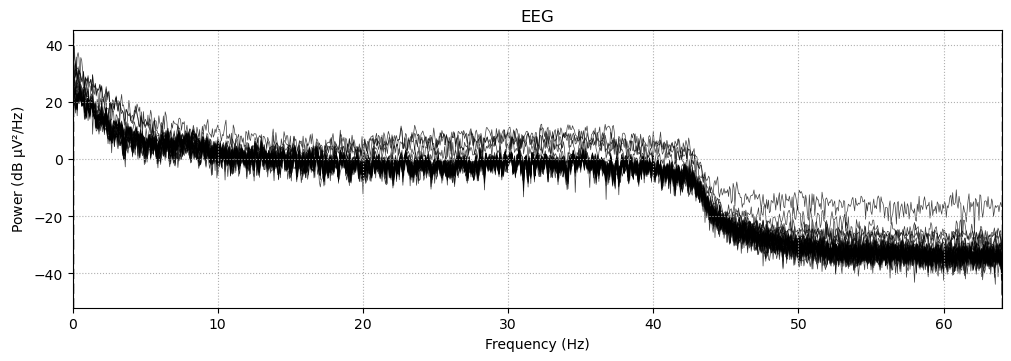

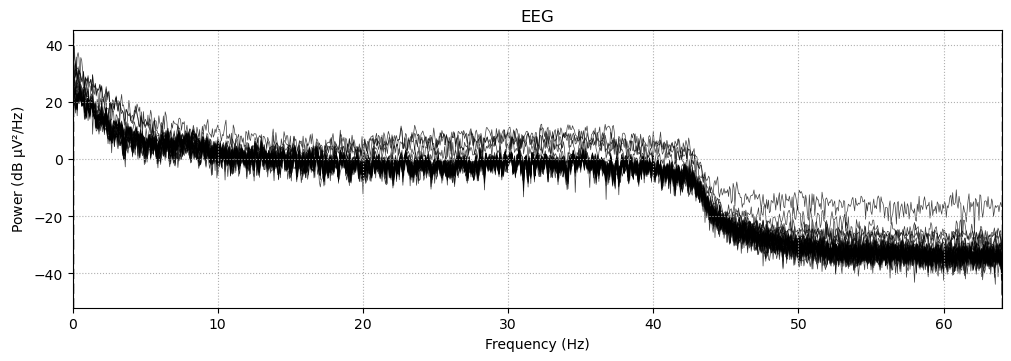

In [5]:
# plot spectrogram
spect = raw.plot_psd()
spect

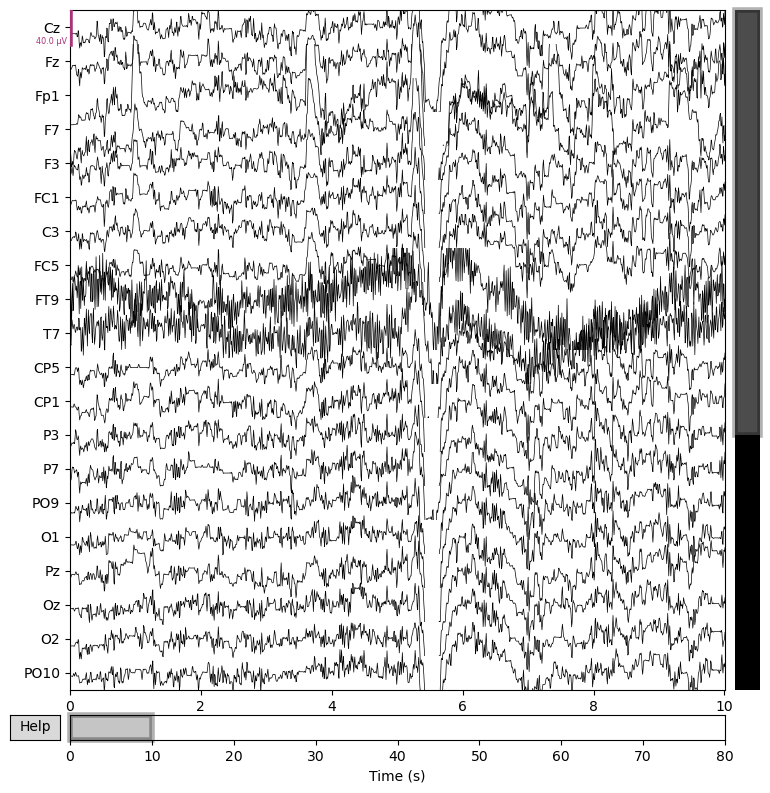

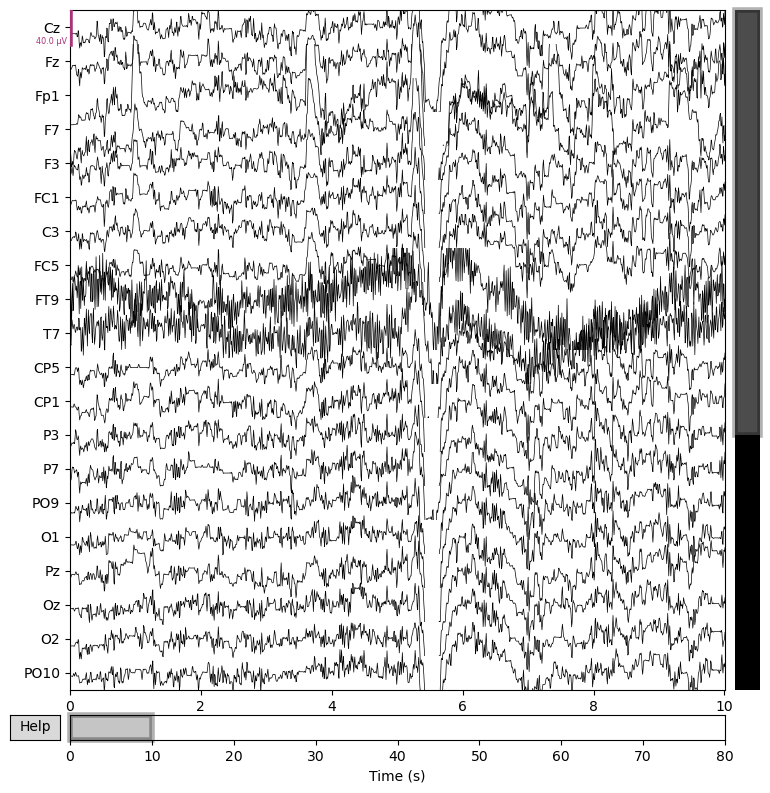

In [6]:
# plot raw data
plot = raw.plot()
plot

In [7]:
# Set montage
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

<Raw | 3784258358_eeg.fif, 32 x 10240 (80.0 s), ~2.5 MB, data loaded>

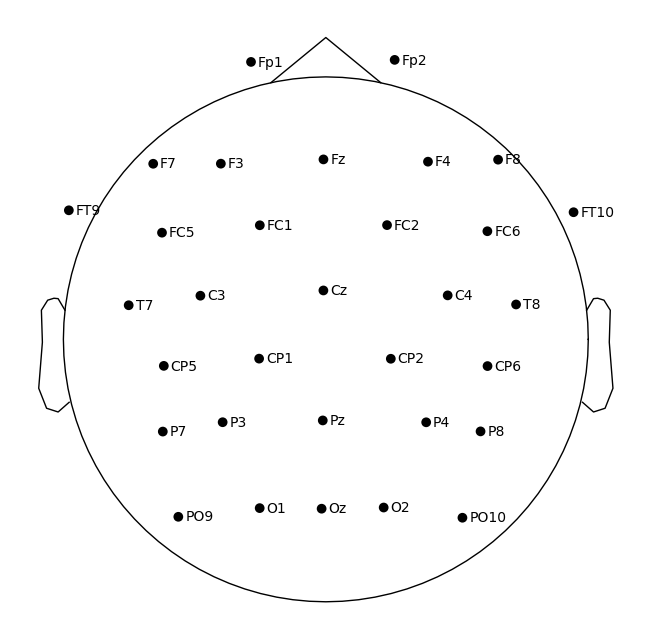

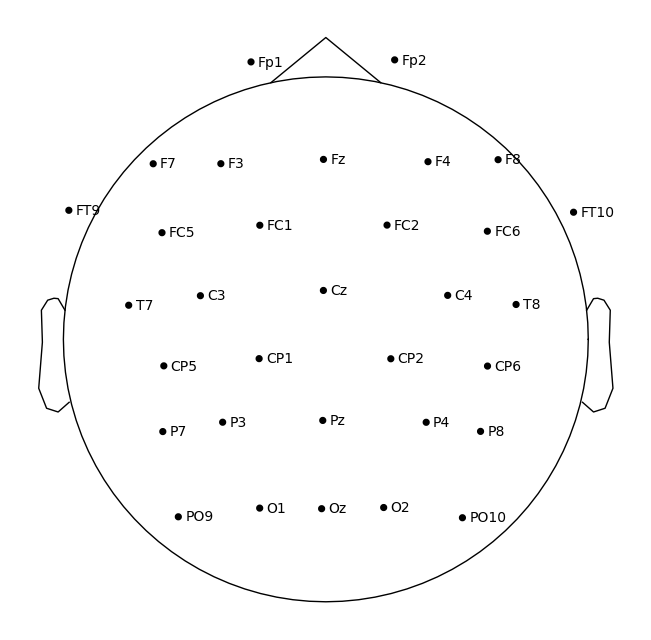

In [8]:
raw.get_montage().plot()

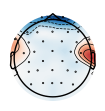

(<matplotlib.image.AxesImage at 0x7f7da46a43d0>,
 <matplotlib.contour.QuadContourSet at 0x7f7da4687350>)

In [9]:
mne.viz.plot_topomap(raw.get_data()[:, 45], raw.info, show=True)

The same can be done with the pruned dataset. 
Note that some preprocesing steps were applied:
- Only EEG channels were kept
- Indipendent Component Analysis was applied to remove eye artifacts
- Bad channels were removed and interpolated
- Bandpass filter was applied between 0.1 and 40 Hz

In [10]:
# open eeg
eeg_file = f"{sample['id']}_eeg.fif"
pruned = mne.io.read_raw_fif(f"{dataset_path}/pruned/train/{eeg_file}", preload=True)

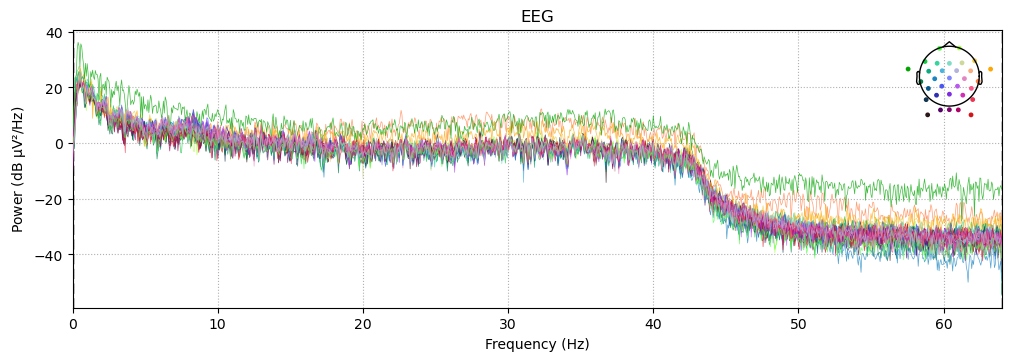

In [11]:
# plot spectrogram
spect = pruned.plot_psd()
spect

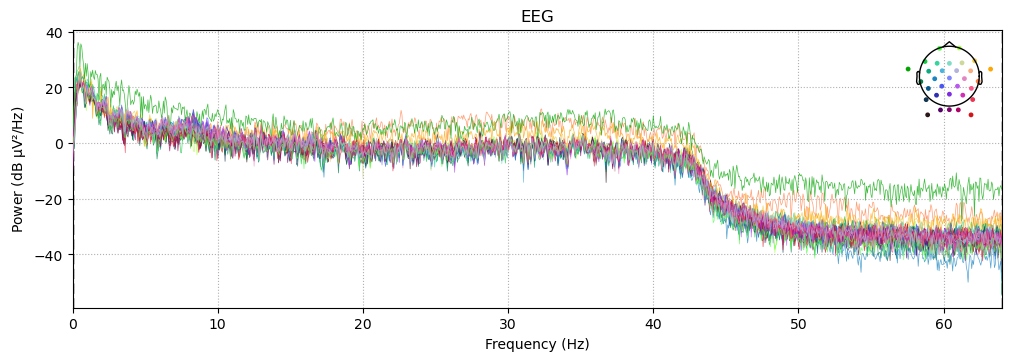

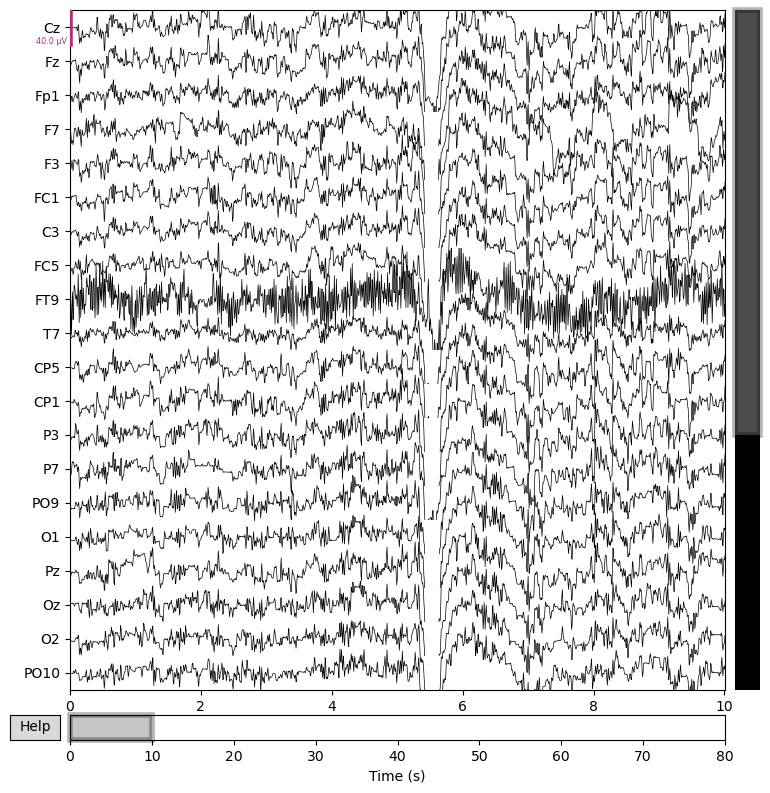

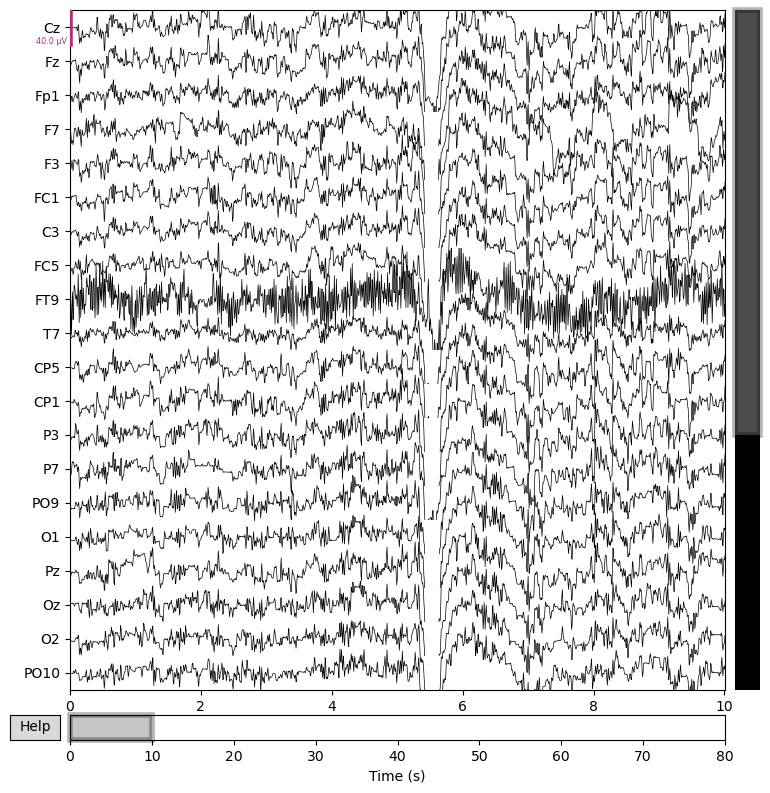

In [12]:
# plot raw data
plot = pruned.plot()
plot


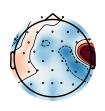

(<matplotlib.image.AxesImage at 0x7f7da4376990>,
 <matplotlib.contour.QuadContourSet at 0x7f7da426ac90>)

In [13]:
# Set montage
montage = mne.channels.make_standard_montage('standard_1020')
pruned.set_montage(montage)
mne.viz.plot_topomap(pruned.get_data()[:, 45], raw.info, show=True)

For convenience, we can use the EremusDataset class to load the data

In [14]:
eremus_raw = EremusDataset(
    subdir = 'raw',  # 'raw', 'pruned', 'preprocessed' . Indicates the type of data to load and the directory to load it from
    split_dir = '../data/splits', # Directory where the splits are stored
    split = "train", # 'train', 'val_trial', 'val_subject', 'test_trial', 'test_subject'
    task="emotion_recognition", # 'emotion_recognition', 'subject_identification'
    ext = "fif", # fif for raw and pruned data, npy for preprocessed data
    prefix="../", # used to reference the directory where config.json is stored starting from the directory where this script is run. If your script is run from the same directory as config.json, you can remove this argument
    transform=None, # transform to apply to the data
)

100%|██████████| 223/223 [00:02<00:00, 91.04it/s]


In [15]:
eremus_raw[0]

{'id': 3784258358,
 'eeg': array([[7.20000025e-05, 7.20000025e-05, 7.20000025e-05, ...,
         1.51000000e-04, 1.51000000e-04, 1.51000000e-04],
        [4.91000013e-04, 4.98700014e-04, 5.06400014e-04, ...,
         8.17599997e-04, 8.25199997e-04, 8.32999998e-04],
        [8.39999993e-05, 8.49999997e-05, 8.60000000e-05, ...,
         8.09999983e-05, 8.19999987e-05, 8.29999990e-05],
        ...,
        [9.99999975e-05, 9.99999975e-05, 9.99999975e-05, ...,
         8.29999990e-05, 8.29999990e-05, 8.29999990e-05],
        [3.99999999e-06, 3.99999999e-06, 3.99999999e-06, ...,
         3.99999999e-06, 3.99999999e-06, 3.99999999e-06],
        [3.99999999e-06, 3.99999999e-06, 3.99999999e-06, ...,
         3.99999999e-06, 3.99999999e-06, 3.99999999e-06]]),
 'label': 0}

# Understanding emotions

Emotions were self-assessed by subjects after each trial using the Geneva Emotion Wheel https://www.unige.ch/cisa/gew

The wheel is divided into 20 emotion families and are places in a circle according to a valence power reference system:
- emotions at the *right* have positive valence
- emotions at the *left* have negative valence
- emotions at the *top* have power (dominance)
- emotions at the *bottom* low power (dominance)

It is possible to divide the circle into 4 groups that correspond to our emotional labels:
- 0 indicates an emotion with high valence and high power (e.g. Joy)
- 1 indicates an emotion with high valence and low power (e.g. Relief)
- 2 indicates an emotion with low valence and low power (e.g. Sadness)
- 3 indicates an emotion with low valence and high power (e.g. Anger)

Although the wheel is a discrete representation of emotions, we can use the valence and power to create a continuous representation.
Coordinates were calculated by the authors of the wheel and are available in the gew file together with emotion terms.

In [16]:
from src.gew import *

vd_coordinates

{0: (0.61, 0.25),
 1: (0.67, 0.19),
 2: (0.72, 0.15),
 3: (0.68, 0.07),
 4: (0.71, 0.02),
 5: (0.77, -0.03),
 6: (0.58, -0.16),
 7: (0.66, -0.09),
 8: (0.66, -0.36),
 9: (-0.05, -0.55),
 10: (-0.68, -0.35),
 11: (-0.57, -0.27),
 12: (-0.7, -0.19),
 13: (-0.61, -0.16),
 14: (-0.77, -0.12),
 15: (-0.61, 0.07),
 16: (-0.68, 0.2),
 17: (-0.55, 0.43),
 18: (-0.45, 0.43),
 19: (-0.37, 0.47),
 20: (0, 0),
 21: None}

In [17]:
emotions

{0: 'Interest',
 1: 'Amusement',
 2: 'Pride',
 3: 'Joy',
 4: 'Pleasure',
 5: 'Contentment',
 6: 'Love',
 7: 'Admiration',
 8: 'Relief',
 9: 'Compassion',
 10: 'Sadness',
 11: 'Guilt',
 12: 'Regret',
 13: 'Shame',
 14: 'Disappointment',
 15: 'Fear',
 16: 'Disgust',
 17: 'Contempt',
 18: 'Hate',
 19: 'Anger',
 20: 'NO EMOTION FELT',
 21: 'DIFFERENT EMOTION FELT'}

# Using music data

Although we won't use music data in our baseline, you are free to use it. To load music data, you can use Spotify API and the spotipy library

In [18]:
!pip install spotipy

In [19]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Replace with your own credentials
client_id = 'YOUR_CLIENT_ID'
client_secret = 'YOUR_CLIENT_SECRET'

# Authenticate with the Spotify API
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [ ]:

# The Spotify track ID you want to fetch
track_id = '0h9fnCSnbUgOEgibnQByFv'

# Fetch the track information
track = sp.track(track_id)

# Print the track information
print(f"Track Name: {track['name']}")
print(f"Artist: {track['artists'][0]['name']}")
print(f"Album: {track['album']['name']}")
print(f"Release Date: {track['album']['release_date']}")
print(f"Track URL: {track['external_urls']['spotify']}")

# get the audio features of the track
audio_features = sp.audio_features(track_id)[0]

audio_features